In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from scipy import stats


In [53]:
import statsmodels.formula.api as smf
import statsmodels.api         as sm
import scipy
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [54]:
from django.contrib.admin.utils import flatten

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [169]:
import numpy as np

#### Load listings dataset

In [55]:
df_L = pd.read_csv('data/listings.csv', encoding = "ISO-8859-1")

## Load Venues dataset and create the traveler dataset

In [99]:
df_venues = pd.read_csv('data/venues.csv', encoding = "ISO-8859-1")

In [100]:
df_venues.head()

,city,id,latitude,longitude,name,rating,types
0,new york city,b1a0d113cb17d1d85f0e12700dd71f36bddedc54,40.601540,-73.729636,A Bacon Yacht Charter,NaN,"['restaurant', 'food', 'point_of_interest', 'e..."
1,new york city,8799bb8d8ac7c2e1933f92ac1ef0f69a5e0b37c1,40.608921,-73.728256,Mezzanote,NaN,"['restaurant', 'food', 'point_of_interest', 'e..."
2,new york city,f2390680116af4d62e0da6f0432d33e94b9cb0e6,40.616978,-73.730349,Prime Bistro,4.0,"['bar', 'restaurant', 'food', 'point_of_intere..."
3,new york city,e9294eb56025e8eb29b937dc0aca29fd3059b9ab,40.617318,-73.730637,Rita's Ice,4.6,"['restaurant', 'food', 'point_of_interest', 'e..."
4,new york city,5c7b72c7bf9e7bc4f94baf09db1252088087f65d,40.618371,-73.728178,Cho-Sen Island,4.4,"['restaurant', 'food', 'point_of_interest', 'e..."


#### The rating column has outliers and types column has text which needs to be processed to deaw conclusiond

In [101]:
df_venues.columns

Index(['city', 'id', 'latitude', 'longitude', 'name', 'rating', 'types'], dtype='object')

In [102]:
df_venues.shape

(267958, 7)

In [103]:
ven_cities = pd.unique(df_venues.city)
ven_cities

array(['new york city', 'denver', 'chicago', 'boston', 'washington dc'],
      dtype=object)

#### So, the 'city' column is not really cities, but rather metro areas with the city (total 5 of them ) in the center of it.

The 'types' column shows the different way the particulr venue can be described, e.g restaurant or chirch or point of interest..

there are total of 2328 of the unique combinations

In [104]:
ven_types = pd.unique(df_venues.types)
ven_types.shape

(2328,)

In [106]:
df_venues.dtypes

city          object
id            object
latitude     float64
longitude    float64
name          object
rating       float64
types         object
dtype: object

### Explore the 'type' column: 
-  each row is a string which indicates the type or category of the venue could possibly belong to.

In [107]:
all_types = df_venues.types.tolist()

In [108]:
print(type(all_types[0]))
## could be converted to list
all_types[0].split(',')

<class 'str'>


["['restaurant'", " 'food'", " 'point_of_interest'", " 'establishment']"]

In [109]:
all_types[0].split(',')[2]

" 'point_of_interest'"

### find the distribution: number of categories per 'type'/ per each rows

In [110]:
num_types = [ len(all_types[i].split(',')) for i in range(df_venues.shape[0])] 

len(num_types)

267958

In [111]:
## maximum 12 descriptions/categories  per row
max(num_types)

12

In [112]:
## minimum 3 descriptions/categories  per row
min(num_types)

3

### Destribution of #cat per row in the dataset

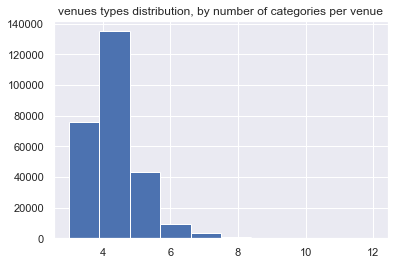

In [113]:
sns.set()

plt.hist(num_types, bins = 10)

plt.title('venues types distribution, by number of categories per venue');

The distribution has right skew

In [114]:
pd.Series(num_types).skew()

1.126575917919044

### take a copy of df_venues

In [130]:
df_venuesA = df_venues.copy()

In [131]:
## add number of cat per row as a new feature:
df_venuesA['num_types']= num_types

In [132]:
df_venuesA.head(3)

,city,id,latitude,longitude,name,rating,types,num_types
0,new york city,b1a0d113cb17d1d85f0e12700dd71f36bddedc54,40.601540,-73.729636,A Bacon Yacht Charter,NaN,"['restaurant', 'food', 'point_of_interest', 'e...",4
1,new york city,8799bb8d8ac7c2e1933f92ac1ef0f69a5e0b37c1,40.608921,-73.728256,Mezzanote,NaN,"['restaurant', 'food', 'point_of_interest', 'e...",4
2,new york city,f2390680116af4d62e0da6f0432d33e94b9cb0e6,40.616978,-73.730349,Prime Bistro,4.0,"['bar', 'restaurant', 'food', 'point_of_intere...",5


In [224]:
#all_types

### It would be interesting to see how many unique categories are in the dataset

In [133]:
all_items = []
for row in range(df_venuesA.shape[0]):
    l = all_types[row].split(',')
    for j in range(len(l)):
        if j == 0:
            all_items.append(l[j][1:])
        elif j==len(l)-1:
            all_items.append(l[j][:-1])
        else:
            all_items.append(l[j])
    

In [134]:
all_items[:8]

["'restaurant'",
 " 'food'",
 " 'point_of_interest'",
 " 'establishment'",
 "'restaurant'",
 " 'food'",
 " 'point_of_interest'",
 " 'establishment'"]

In [135]:
##find unique items:
u_items = pd.unique(all_items)

print('total number of unique types',len(u_items))

total number of unique types 198


There are total of 198 unique words describing to what category the venue belongs

In [136]:
#u_items

In [137]:
all_types = flatten(df_venuesA.types)
print('total of ', len(pd.unique(all_types)), 'unique combos  in types')

total of  2328 unique combos  in types


In [138]:
df_venuesA.shape[0]

267958

- 2328 unques in df (267958)
- x uniques in sample (1000)
 -  X ~ 8
- SO, if we take a sampe with only 1000 rows, we would expect to see 8 unique combos

In [33]:
### add column 

In [34]:
#all_types

##### How are the venues distiributed throughout the metro areas?

In [139]:
df_venuesA.groupby(['city']).size()

city
boston            14243
chicago           65645
denver            38506
new york city    130588
washington dc     18976
dtype: int64

- Most of the venues are located in NYC metro area (or nea New York?)

#### DO average ratings of venues differ from metro to metro area

In [140]:

df_venuesA.groupby(['city'])['rating'].mean()

city
boston           4.100188
chicago          4.091885
denver           4.011665
new york city    4.064239
washington dc    4.001884
Name: rating, dtype: float64

- The mean of this variable is pretty much the same for all the metro areas
- it is also close to 4 if to average across the whole dataset!

In [141]:
mean_rating = df_venuesA['rating'].mean()
mean_rating

4.058323207776468

#### replace each NaN in 'rating ' wiht averge per column rating

In [145]:
rating_i = df_venuesA['rating'].fillna(mean_rating)

In [146]:
rating_i

0         4.058323
1         4.058323
2         4.000000
3         4.600000
4         4.400000
            ...   
267953    4.058323
267954    3.900000
267955    4.300000
267956    4.058323
267957    4.500000
Name: rating, Length: 267958, dtype: float64

- take a look at the distribution of the rating variable (whole dataset and each metro areas)

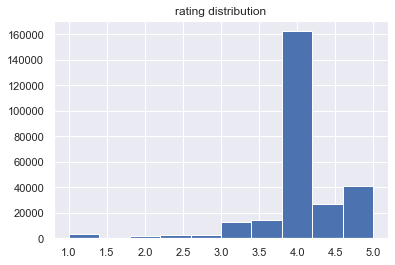

In [147]:
plt.hist(rating_i, bins = 10)

plt.title('rating distribution');

- the distribution looks heavily left skewed, althogh most of the venues have close to average (4) rating

In [148]:
rating_i.skew()

-2.05979546690871

- impute NaNs in the rating column with average percolumn

In [149]:

df_venuesA['rating_i']=rating_i

In [150]:
df_venuesA.head()

,city,id,latitude,longitude,name,rating,types,num_types,rating_i
0,new york city,b1a0d113cb17d1d85f0e12700dd71f36bddedc54,40.601540,-73.729636,A Bacon Yacht Charter,4.058323,"['restaurant', 'food', 'point_of_interest', 'e...",4,4.058323
1,new york city,8799bb8d8ac7c2e1933f92ac1ef0f69a5e0b37c1,40.608921,-73.728256,Mezzanote,4.058323,"['restaurant', 'food', 'point_of_interest', 'e...",4,4.058323
2,new york city,f2390680116af4d62e0da6f0432d33e94b9cb0e6,40.616978,-73.730349,Prime Bistro,4.000000,"['bar', 'restaurant', 'food', 'point_of_intere...",5,4.000000
3,new york city,e9294eb56025e8eb29b937dc0aca29fd3059b9ab,40.617318,-73.730637,Rita's Ice,4.600000,"['restaurant', 'food', 'point_of_interest', 'e...",4,4.600000
4,new york city,5c7b72c7bf9e7bc4f94baf09db1252088087f65d,40.618371,-73.728178,Cho-Sen Island,4.400000,"['restaurant', 'food', 'point_of_interest', 'e...",4,4.400000


In [151]:
### check for NaNs
df_venuesA.isnull().sum()

city         0
id           0
latitude     0
longitude    0
name         0
rating       0
types        0
num_types    0
rating_i     0
dtype: int64

In [152]:
df_venuesA[df_venuesA['city']=='boston'].rating_i

234739    3.900000
234740    3.300000
234741    4.700000
234742    4.200000
234743    4.100000
            ...   
248977    4.058323
248978    4.058323
248979    2.500000
248980    3.000000
248981    4.058323
Name: rating_i, Length: 14243, dtype: float64

In [153]:
cities = list(set(df_venuesA.city.tolist()))

In [154]:
cities

['washington dc', 'chicago', 'new york city', 'denver', 'boston']

In [155]:
#df_venuesA[df_venuesA['rating_i']==1]

### Venues rating distribution

#### Transformations of rating variable

- distiribution of 'rating' for different metro aras 

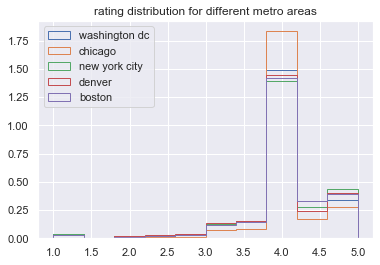

In [156]:
bins = np.linspace(1, 5, 10)
for city in cities:
    bins = np.linspace(1, 5, 10)
    plt.hist(df_venuesA[df_venuesA['city']==city].rating_i,histtype = 'step', density = True, label = city)
    plt.legend(loc='upper left')
    plt.title('rating distribution for different metro areas');

In [157]:
df_venuesA['rating_i'].skew()

-2.05979546690871

### Boxcox transform to fix skewness

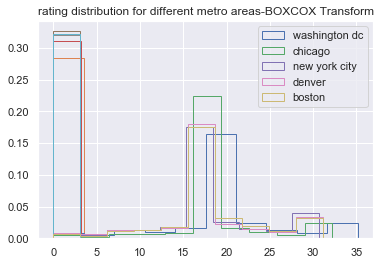

In [159]:
bins = np.linspace(1, 5, 10)
for city in cities:
    bins = np.linspace(1, 5, 10)
    plt.hist(stats.boxcox(df_venuesA[df_venuesA['city']==city].rating_i),histtype = 'step', density = True, label = city)
    plt.legend(loc='upper right')
    plt.title('rating distribution for different metro areas-BOXCOX Transform');

- much less skewness

In [246]:
pd.Series(stats.boxcox(df_venuesA['rating_i'])[0]).skew()

0.1189046406945206

### Add transformed rating variable:

In [161]:
df_venuesA.columns

Index(['city', 'id', 'latitude', 'longitude', 'name', 'rating', 'types',
       'num_types', 'rating_i'],
      dtype='object')

In [248]:
#df_venuesA['rating_i'].tolist()

In [162]:
stats.boxcox(df_venuesA.rating_i.values)

(array([17.52006534, 17.52006534, 16.81205228, ..., 20.65301272,
        17.52006534, 23.49601911]), 2.7914213081008517)

In [163]:
bc = stats.boxcox(df_venuesA.rating_i.values)[0]

In [164]:
bc

array([17.52006534, 17.52006534, 16.81205228, ..., 20.65301272,
       17.52006534, 23.49601911])

In [165]:
df_venuesA['rating_boxcox'] = bc

In [166]:
df_venuesA.head()

,city,id,latitude,longitude,name,rating,types,num_types,rating_i,rating_boxcox
0,new york city,b1a0d113cb17d1d85f0e12700dd71f36bddedc54,40.601540,-73.729636,A Bacon Yacht Charter,4.058323,"['restaurant', 'food', 'point_of_interest', 'e...",4,4.058323,17.520065
1,new york city,8799bb8d8ac7c2e1933f92ac1ef0f69a5e0b37c1,40.608921,-73.728256,Mezzanote,4.058323,"['restaurant', 'food', 'point_of_interest', 'e...",4,4.058323,17.520065
2,new york city,f2390680116af4d62e0da6f0432d33e94b9cb0e6,40.616978,-73.730349,Prime Bistro,4.000000,"['bar', 'restaurant', 'food', 'point_of_intere...",5,4.000000,16.812052
3,new york city,e9294eb56025e8eb29b937dc0aca29fd3059b9ab,40.617318,-73.730637,Rita's Ice,4.600000,"['restaurant', 'food', 'point_of_interest', 'e...",4,4.600000,25.005362
4,new york city,5c7b72c7bf9e7bc4f94baf09db1252088087f65d,40.618371,-73.728178,Cho-Sen Island,4.400000,"['restaurant', 'food', 'point_of_interest', 'e...",4,4.400000,22.045582


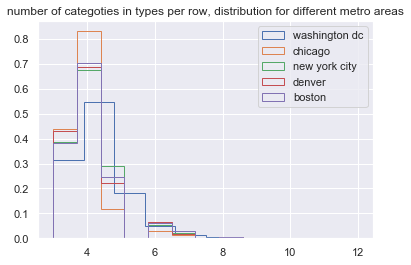

In [168]:
#normalized counts, log
for city in cities:
    bins = np.linspace(1, 12, 12)
    plt.hist(df_venuesA[df_venuesA['city']==city].num_types,histtype = 'step',density = True, label = city)
    plt.legend(loc='upper right')
    plt.title('number of categoties in types per row, distribution for different metro areas');

### Select random sample N= 1151 (same as in events dataset) to do T-SNE, number of rows corresponds to venues.csv

In [171]:
types_rating_sample = df_venuesA.sample(1151, random_state=1)



#### labels =  ordinal ratings

In [257]:
### Labels - ratings
labels = types_rating_sample.rating_i

 - Labels binary rating_i <4.5 and rating_i >= 4.5

In [172]:
labels_binary = [0 if x <4.5 else  1 for x in types_rating_sample.rating_i.values]
#labels_binary = []

In [173]:
# binning the labels RATINGS:
## partition outcome var into 3 categories: 0<var<=Q1(27%), Q1<var<=Q3(27%)
## var>Q3

In [174]:
def bins(df,col,low,mid):
    labels_bins = []
    for i in df[col].values:
        if i<=low:
            labels_bins.append(0)
        elif i>low and i<=mid:
        
            labels_bins.append(1)
        else:
            labels_bins.append(2)
    return labels_bins
    

In [175]:
labels_q = np.array(bins(types_rating_sample,'rating_i',4,4.5))
print('3 level ratings bins', '\n')
print('dimensions',labels_q.shape)
labels_q[:20]



3 level ratings bins 

dimensions (1151,)


array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1])

#### Labels -  binning the transformed (boxcox) RATINGS:

In [176]:
labels_boxcox = np.array(bins(types_rating_sample,'rating_boxcox',5,25))
print('3 level ratings boxcox', '\n')
print('dimensions',labels_boxcox.shape)
labels_boxcox[:20]

3 level ratings boxcox 

dimensions (1151,)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1])

#### Labels - metro areas

In [177]:
labels_city = types_rating_sample.city

In [178]:
from yellowbrick.text import TSNEVisualizer

In [179]:
tfidf  = TfidfVectorizer()

docs   = tfidf.fit_transform(types_rating_sample.types)



In [180]:
types_rating_sample.rating_i.isnull().sum()

0

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


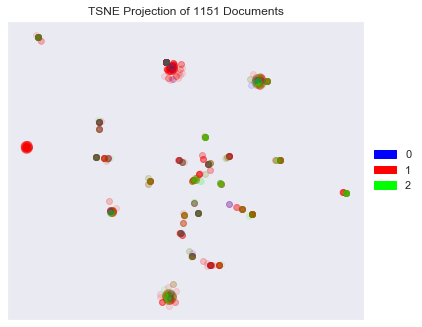

In [181]:
# Create & visualize vectors, this one is using a labels_boxcox (rating transformed by boxcox method)
sns.set()
tsne = TSNEVisualizer(colormap = 'brg',decompose = 'svd',decompose_by = 20, alpha  = 0.1)
tsne.fit(docs, labels_boxcox)
tsne.poof()

- classes 0 (<5) and 2 (>25) transformed rating variable are not reall well separated

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


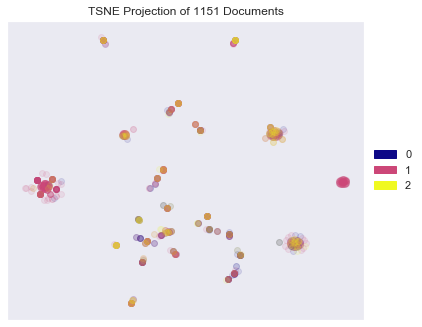

In [268]:
# Create & visualize vectors, binned rating labels
sns.set()
tsne = TSNEVisualizer(colormap = 'plasma',decompose = 'svd',decompose_by = 20, alpha  = 0.1)
tsne.fit(docs, labels_q)
tsne.poof()

- looks like this is the best separation while 0 and 2 are still together

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

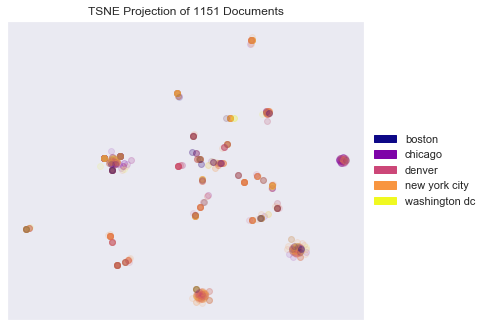

In [182]:
# Create & visualize vectors, use metro areas as lables
## no difference in ratings!
sns.set()
tsne = TSNEVisualizer(colormap = 'plasma',decompose = 'svd',decompose_by = 20, alpha  = 0.1)
tsne.fit(docs, labels_city)
tsne.poof()

#### is it possible that  the more more multipurpose place is the better/worse is the rating?

In [183]:
df_venuesA.head()

,city,id,latitude,longitude,name,rating,types,num_types,rating_i,rating_boxcox
0,new york city,b1a0d113cb17d1d85f0e12700dd71f36bddedc54,40.601540,-73.729636,A Bacon Yacht Charter,4.058323,"['restaurant', 'food', 'point_of_interest', 'e...",4,4.058323,17.520065
1,new york city,8799bb8d8ac7c2e1933f92ac1ef0f69a5e0b37c1,40.608921,-73.728256,Mezzanote,4.058323,"['restaurant', 'food', 'point_of_interest', 'e...",4,4.058323,17.520065
2,new york city,f2390680116af4d62e0da6f0432d33e94b9cb0e6,40.616978,-73.730349,Prime Bistro,4.000000,"['bar', 'restaurant', 'food', 'point_of_intere...",5,4.000000,16.812052
3,new york city,e9294eb56025e8eb29b937dc0aca29fd3059b9ab,40.617318,-73.730637,Rita's Ice,4.600000,"['restaurant', 'food', 'point_of_interest', 'e...",4,4.600000,25.005362
4,new york city,5c7b72c7bf9e7bc4f94baf09db1252088087f65d,40.618371,-73.728178,Cho-Sen Island,4.400000,"['restaurant', 'food', 'point_of_interest', 'e...",4,4.400000,22.045582


In [273]:
#df_venuesA.drop(['rating'], axis=1, inplace=True)

In [187]:
model_ref = smf.ols(formula = "rating_i ~ num_types*city + city + num_types ", data = df_venuesA).fit()
model_ref.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rating_i   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     81.07
Date:                Fri, 10 Apr 2020   Prob (F-statistic):          4.86e-151
Time:                        00:13:23   Log-Likelihood:            -2.5167e+05
No. Observations:              267958   AIC:                         5.034e+05
Df Residuals:                  267948   BIC:                         5.035e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           4.2325      0.023    182.097      0.000       4.187       4.278
city[T.chicago]                    -0.1601      0.027     -6.034      0.000      -0.212      -0.108
city[T.denver]                      0.0579      0.027      2.128      0.033       0.005       0.111
city[T.new york city]              -0.1129      0.025     -4.593      0.000      -0.161      -0.065
city[T.washington dc]               0.0440      0.031      1.421      0.155      -0.017       0.105
num_types                          -0.0374      0.006     -6.717      0.000      -0.048      -0.026
num_types:city[T.chicago]           0.0365      0.006      5.658      0.000       0.024       0.049
num_types:city[T.denver]           -0.0264      0.007     -4.035      0.000      -0.039      -0.014
num_types:city[T.new york city]     0.0231      0.006      3.920      0.000       0.012       0.035
num_types:city[T.washington dc]    -0.0238      0.007     -3.191      0.001      -0.038      -0.009
==============================================================================
Omnibus:                   122273.636   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           924856.520
Skew:                          -2.050   Prob(JB):                         0.00
Kurtosis:                      11.126   Cond. No.                         226.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- the more multipurpose the place is the worse are the ratings, although the coeddicient is really small
- if interaction is added city , the effect more pronounced in NY and Chicago


### Explore correlations in venues dataset

In [188]:
df_venuesA.columns

Index(['city', 'id', 'latitude', 'longitude', 'name', 'rating', 'types',
       'num_types', 'rating_i', 'rating_boxcox'],
      dtype='object')

#### drop rating  and 'types' use label_q : 0,1,2 , add new column 'types_rating'



In [189]:
df_venuesA.drop(['rating'], axis = 1, inplace = True)

In [191]:
df_venuesA.drop(['rating_boxcox'], axis = 1, inplace = True)

In [202]:
#
df_venuesA.drop(['types'], axis = 1, inplace = True)

### correlation matrix for venue DF

In [203]:
corr = df_venuesA.corr()
corr['rating_i'].sort_values(ascending = False)

rating_i     1.000000
latitude     0.021421
longitude    0.011016
num_types   -0.035124
Name: rating_i, dtype: float64

In [ ]:
sns.heatmap()

In [249]:
cmap = sns.color_palette('Blues')

(4.0, 0.0)

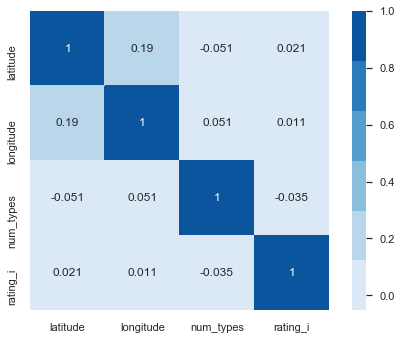

In [250]:
import seaborn as sns

ax = sns.heatmap(corr, cmap = cmap,annot=True,square = True) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

##### Conclusion: 
- there is no strongly correlated variables
- as for the 'types' variable : the more multipurpose the place is the less in its rating

In [194]:
set(df_venuesA.city)

{'boston', 'chicago', 'denver', 'new york city', 'washington dc'}

### Add 'state' column to venues

In [195]:
states = ['NY','CO','IL','MA','DC']
metros = ['new york city','denver','chicago','boston','washington dc']

In [196]:
def states(m):
    if m=='new york city':
        return 'NY'
    elif m=='denver':
        return 'CO'
    elif m=='chicago':
        return 'IL'
    elif m == 'boston':
        return 'MA'
    else:
        return 'DC'
   

In [197]:
df_venuesA.loc[:,'state'] = df_venuesA.apply(lambda x: states(x.city), axis=1)


In [251]:
df_venuesA.head(2)

,city,id,latitude,longitude,name,num_types,state,types_rating
0,new york city,b1a0d113cb17d1d85f0e12700dd71f36bddedc54,40.601540,-73.729636,A Bacon Yacht Charter,4,NY,1
1,new york city,8799bb8d8ac7c2e1933f92ac1ef0f69a5e0b37c1,40.608921,-73.728256,Mezzanote,4,NY,1


In [204]:

types_rating = np.array(bins(df_venuesA,'rating_i',4,4.5))

df_venuesA['types_rating'] = types_rating

In [205]:
### drop rating_i as it correlates with types_rating
df_venuesA.drop(['rating_i'], axis = 1, inplace=True)

In [206]:
df_venuesA.head()

,city,id,latitude,longitude,name,num_types,state,types_rating
0,new york city,b1a0d113cb17d1d85f0e12700dd71f36bddedc54,40.601540,-73.729636,A Bacon Yacht Charter,4,NY,1
1,new york city,8799bb8d8ac7c2e1933f92ac1ef0f69a5e0b37c1,40.608921,-73.728256,Mezzanote,4,NY,1
2,new york city,f2390680116af4d62e0da6f0432d33e94b9cb0e6,40.616978,-73.730349,Prime Bistro,5,NY,0
3,new york city,e9294eb56025e8eb29b937dc0aca29fd3059b9ab,40.617318,-73.730637,Rita's Ice,4,NY,2
4,new york city,5c7b72c7bf9e7bc4f94baf09db1252088087f65d,40.618371,-73.728178,Cho-Sen Island,4,NY,1


#### create "travelers visit Google places" dataset: will mimic the events dataset

In [207]:
events_df = pd.read_csv('data/events_US.csv', encoding = "ISO-8859-1")

In [252]:
events_df.head(3)

,date,city,state,event_name,quarter
0,2017-02-01,St. Louis,MO,NHL Winter Classic,1
1,2017-04-01,New York,NY,National Board of Review of Motion Pictures Aw...,2
2,2017-05-01,New York,NY,Winter Jazzfest NYC,2


In [209]:
events_df['date'] = pd.to_datetime(events_df['date'])
### Adding quorter column
q = events_df.date.dt.quarter
events_df['quarter']=q
events_df.head(3)

,date,city,state,event_name,quarter
0,2017-02-01,St. Louis,MO,NHL Winter Classic,1
1,2017-04-01,New York,NY,National Board of Review of Motion Pictures Aw...,2
2,2017-05-01,New York,NY,Winter Jazzfest NYC,2


In [210]:
events_df.shape

(1151, 5)

In [211]:
tr_dates = events_df.date.tolist()

#### Add tr_dates to the sample of df_venuesA DF with 1151 rows: 'types_rating_sample'

### Take a sample from engineered df_venuesA DF:


In [212]:
df_venuesA_1151 = df_venuesA.sample(1151, random_state=1)

In [213]:
df_venuesA_1151['date']=tr_dates

In [214]:
tr_df = df_venuesA_1151

In [215]:
tr_df.head()

,city,id,latitude,longitude,name,num_types,state,types_rating,date
171794,chicago,2622c79ed752724e7f4f691c185be6aeee145344,41.949237,-87.654804,Wrigley Rooftops 1010 West Waveland,5,IL,0,2017-02-01
91296,new york city,1d4e080afa70d25050471feb96c8154455b91f6d,40.756259,-73.986508,Walgreens Pharmacy,5,NY,0,2017-04-01
128280,new york city,cba18363393cad37acdd3c5246e4c4738be153e0,40.811669,-73.944428,Harlem Your Way Tours Unlimited,3,NY,1,2017-05-01
265518,washington dc,3adf58a2e8c0bc1996c669df31cef1b145696647,38.989005,-77.070891,East-West Hwy & Brookeville Rd,4,DC,1,2017-05-01
262961,washington dc,b0a227a0bf0d80695cb7d4355bc85d3b3e42bb86,38.893633,-76.985282,C St NE & 14th St NE,4,DC,1,2017-05-01


In [216]:
## Rename column 'name ' to 'destination'
tr_df.rename(columns={'name':'destination'}, inplace=True)

In [217]:
tr_df.head(3)

,city,id,latitude,longitude,destination,num_types,state,types_rating,date
171794,chicago,2622c79ed752724e7f4f691c185be6aeee145344,41.949237,-87.654804,Wrigley Rooftops 1010 West Waveland,5,IL,0,2017-02-01
91296,new york city,1d4e080afa70d25050471feb96c8154455b91f6d,40.756259,-73.986508,Walgreens Pharmacy,5,NY,0,2017-04-01
128280,new york city,cba18363393cad37acdd3c5246e4c4738be153e0,40.811669,-73.944428,Harlem Your Way Tours Unlimited,3,NY,1,2017-05-01


### Save traveller database :

In [311]:
#tr_df.to_csv("data/travelers.csv", index=False)

##### Looking at venues and listing data: 'city' and 'metropolitan' variables 

In [312]:

df_venues_city_unique = pd.unique(df_venuesA.city)
df_L_metro_unique = pd.unique(df_L.metropolitan)
print('venues DF city column is correspondng to metro areas of listing DF')
print('venue DF city column uniques:',df_venues_city_unique)
print('listing DF metropolitan column  uniques', df_L_metro_unique)

venues DF city column is correspondng to metro areas of listing DF
venue DF city column uniques: ['new york city' 'denver' 'chicago' 'boston' 'washington dc']
listing DF metropolitan column  uniques ['NYC' 'denver' 'chicago' 'boston' 'dc']


## Listings

In [8]:
## create a copy of df:
df=df_L.copy()


In [9]:
df.columns

Index(['accommodates', 'amenities', 'availability_30', 'bathrooms', 'bed_type',
       'bedrooms', 'beds', 'cancellation_policy', 'city', 'has_availability',
       'host_id', 'id', 'instant_bookable', 'latitude', 'longitude',
       'metropolitan', 'name', 'price', 'property_type',
       'review_scores_checkin', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_rating', 'review_scores_value', 'room_type', 'state',
       'weekly_price', 'zipcode'],
      dtype='object')

In [10]:
df.shape

(59824, 29)

#### Check NaNs 

In [11]:
df._get_numeric_data().isna().sum()

accommodates                      61
availability_30                    0
bathrooms                        202
bedrooms                          95
beds                             109
has_availability               59824
host_id                            0
id                                 0
latitude                           0
longitude                          0
price                              0
review_scores_checkin          14346
review_scores_cleanliness      14280
review_scores_communication    14285
review_scores_location         14349
review_scores_rating           14200
review_scores_value            14354
weekly_price                   46386
dtype: int64

#### replace the NaNs in reviews columns with median per column value

In [12]:
reviews_list = ['review_scores_checkin','review_scores_cleanliness',
                'review_scores_communication','review_scores_location',        
                'review_scores_rating','review_scores_value']   

In [13]:
for k in reviews_list:
    df[k] = df[k].fillna(df[k].median())


In [14]:
df._get_numeric_data().isna().sum()

accommodates                      61
availability_30                    0
bathrooms                        202
bedrooms                          95
beds                             109
has_availability               59824
host_id                            0
id                                 0
latitude                           0
longitude                          0
price                              0
review_scores_checkin              0
review_scores_cleanliness          0
review_scores_communication        0
review_scores_location             0
review_scores_rating               0
review_scores_value                0
weekly_price                   46386
dtype: int64

#### impute other variables with mean value:

In [15]:
other_list = ['accommodates','bathrooms','bedrooms','bedrooms','beds','weekly_price']
for i in other_list:
    df[i] = df[i].fillna(df[i].mean())



In [16]:
df._get_numeric_data().isna().sum()

accommodates                       0
availability_30                    0
bathrooms                          0
bedrooms                           0
beds                               0
has_availability               59824
host_id                            0
id                                 0
latitude                           0
longitude                          0
price                              0
review_scores_checkin              0
review_scores_cleanliness          0
review_scores_communication        0
review_scores_location             0
review_scores_rating               0
review_scores_value                0
weekly_price                       0
dtype: int64

In [17]:
df.drop(['has_availability'], axis = 1, inplace = True)

In [18]:
df._get_numeric_data().isna().sum()

accommodates                   0
availability_30                0
bathrooms                      0
bedrooms                       0
beds                           0
host_id                        0
id                             0
latitude                       0
longitude                      0
price                          0
review_scores_checkin          0
review_scores_cleanliness      0
review_scores_communication    0
review_scores_location         0
review_scores_rating           0
review_scores_value            0
weekly_price                   0
dtype: int64

In [19]:
cat = ['amenities', 'bed_type', 'cancellation_policy','instant_bookable','metropolitan',
       'property_type', 'room_type']

In [20]:
df[cat].isna().sum()

amenities              0
bed_type               0
cancellation_policy    0
instant_bookable       0
metropolitan           0
property_type          4
room_type              0
dtype: int64

In [21]:
df.dropna()

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,host_id,...,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,state,weekly_price,zipcode
0,2.0,"{""Cable TV"",""Wireless Internet"",""Air condition...",24,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,119445,...,10.0,10.0,10.0,10.0,100.0,10.0,Private room,NY,856.471201,10464
1,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",30,1.0,Real Bed,1.0,1.0,flexible,sunnysidebronx,9117975,...,10.0,10.0,10.0,10.0,96.0,10.0,Private room,NY,856.471201,10464
2,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,3.0,Real Bed,3.0,3.0,strict,sunnysidebronx,9815788,...,10.0,10.0,10.0,10.0,96.0,10.0,Entire home/apt,NY,856.471201,10464
3,3.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",8,1.0,Real Bed,1.0,1.0,strict,long island city,13886510,...,10.0,10.0,10.0,10.0,93.0,10.0,Entire home/apt,NY,775.000000,10464
4,4.0,"{Internet,""Wireless Internet"",""Air conditionin...",17,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,28811542,...,10.0,10.0,10.0,10.0,97.0,10.0,Private room,NY,350.000000,10464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59819,2.0,"{Internet,""Wireless Internet"",""Air conditionin...",0,1.0,Real Bed,1.0,1.0,flexible,silver spring,84708427,...,9.0,8.0,9.0,8.0,80.0,9.0,Private room,MD,856.471201,20910
59820,5.0,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",20,1.0,Real Bed,1.0,2.0,flexible,bethesda,16290768,...,10.0,10.0,10.0,10.0,96.0,10.0,Entire home/apt,MD,856.471201,20816
59821,6.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",13,1.0,Real Bed,1.0,3.0,strict,temple hills,31818247,...,10.0,10.0,10.0,10.0,96.0,10.0,Private room,MD,856.471201,20748
59822,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",12,1.0,Real Bed,1.0,1.0,moderate,silver spring,41071649,...,10.0,9.0,10.0,10.0,100.0,10.0,Entire home/apt,MD,856.471201,20910


In [22]:
df.dropna(subset = ['property_type'],how = 'any', axis = 0, inplace = True)

In [23]:
df[cat].isna().sum()

amenities              0
bed_type               0
cancellation_policy    0
instant_bookable       0
metropolitan           0
property_type          0
room_type              0
dtype: int64

In [27]:
### Retain 'metropolitan'
df_d_metro = df.metropolitan.tolist()
set(df_d_metro)

{'NYC', 'boston', 'chicago', 'dc', 'denver'}

In [28]:
df_d = pd.get_dummies(df, columns = ['bed_type','cancellation_policy','instant_bookable','metropolitan','property_type','room_type'], sparse = True)

In [29]:
df_d.shape

(59820, 76)

In [30]:
df_d.head(4)

,accommodates,amenities,availability_30,bathrooms,bedrooms,beds,city,host_id,id,latitude,...,property_type_Tent,property_type_Timeshare,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Vacation home,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2.0,"{""Cable TV"",""Wireless Internet"",""Air condition...",24,1.0,1.0,1.0,sunnysidebronx,119445,7949480,40.852054,...,0,0,0,0,0,0,0,0,1,0
1,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",30,1.0,1.0,1.0,sunnysidebronx,9117975,16042478,40.853491,...,0,0,0,0,0,0,0,0,1,0
2,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,3.0,3.0,3.0,sunnysidebronx,9815788,1886820,40.841144,...,0,0,0,0,0,0,0,1,0,0
3,3.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",8,1.0,1.0,1.0,long island city,13886510,6627449,40.849775,...,0,0,0,0,0,0,0,1,0,0


##### full list of features after converting categorical variables into dymmies

In [224]:
#for i in df_d.columns:
    #print(i)

### Before exploring correlations in the data, remove the 'price' variable for now and add it later

In [32]:
price = df_d['price'].tolist()

In [35]:
### drop price:
df_d.drop(['price'], axis = 1, inplace = True)

In [36]:
### Compute a correlation ,matrix:
cor = df_d.corr()
pd.DataFrame(np.linalg.inv(df_d.corr().values), index = cor.index, columns=cor.columns)



,accommodates,availability_30,bathrooms,bedrooms,beds,host_id,id,latitude,longitude,review_scores_checkin,...,property_type_Tent,property_type_Timeshare,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Vacation home,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
accommodates,4.020385,-0.114119,-0.200213,-0.907674,-2.122850,0.003382,-0.091613,-0.721072,-2.674103,0.000055,...,-2.082091e-01,-1.370254e+00,-7.293364e+00,-3.020373e-01,-2.930096e-01,-2.950532e-01,-1.131255e+00,2.599140e+00,3.515103e+00,1.343989e+00
availability_30,-0.114119,1.105319,0.006557,0.013738,0.005231,-0.077145,-0.003072,0.325942,-21.216665,0.005811,...,-7.098524e-01,-4.598928e+00,-2.480542e+01,-9.865351e-01,-9.872586e-01,-9.898210e-01,-3.839212e+00,1.109468e+01,1.083778e+01,3.553186e+00
bathrooms,-0.200213,0.006557,1.513213,-0.480333,-0.162703,0.011146,-0.015268,0.115490,3.108459,0.020590,...,9.894113e-02,6.373489e-01,3.363781e+00,1.424775e-01,1.409470e-01,1.291527e-01,5.198115e-01,-1.407540e+00,-1.521999e+00,-5.408921e-01
bedrooms,-0.907674,0.013738,-0.480333,2.427008,-0.801805,0.033741,0.026672,0.500208,-1.411782,-0.016889,...,-8.943566e-03,-1.500631e-02,-3.449996e-01,1.084217e-02,-1.387732e-02,-1.219241e-02,-4.639229e-02,8.530600e-02,-1.464959e-01,4.903475e-03
beds,-2.122850,0.005231,-0.162703,-0.801805,3.411837,-0.080753,0.031468,0.489747,0.505561,-0.011105,...,8.691731e-02,5.578969e-01,3.002764e+00,7.084608e-02,1.211688e-01,1.264893e-01,4.694879e-01,-1.209924e+00,-1.168081e+00,-6.140722e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
property_type_Vacation home,-0.295084,-0.989937,0.129187,-0.012189,0.126478,-0.447341,-0.302028,6.611317,1726.395951,-0.053651,...,1.596873e+08,1.046800e+09,5.656116e+09,2.258350e+08,2.258336e+08,2.258443e+08,8.744560e+08,4.754974e+09,4.726599e+09,1.582801e+09
property_type_Villa,-1.131449,-3.839646,0.519920,-0.046417,0.469615,-1.748013,-1.189493,25.965106,6679.287373,-0.210232,...,6.183214e+08,4.053288e+09,2.190091e+10,8.744503e+08,8.744449e+08,8.744864e+08,3.385961e+09,1.841162e+10,1.830175e+10,6.128726e+09
room_type_Entire home/apt,2.596811,11.086668,-1.406489,0.085262,-1.208825,4.905605,3.513887,-45.458946,-19082.018648,0.601799,...,3.360214e+09,2.202666e+10,1.190174e+11,4.752021e+09,4.752021e+09,4.752021e+09,1.840019e+10,-4.046742e+11,-4.023215e+11,-1.347325e+11
room_type_Private room,3.513194,10.830062,-1.520856,-0.146401,-1.167771,4.872282,3.430167,-45.534296,-18984.271016,0.584104,...,3.340679e+09,2.189861e+10,1.183254e+11,4.724394e+09,4.724394e+09,4.724394e+09,1.829322e+10,-4.023215e+11,-3.999826e+11,-1.339492e+11


### Compute VIFs

In [37]:
vifs = pd.Series(np.linalg.inv(df_d.corr().values).diagonal(), index=cor.index)


In [38]:
vifs_df = pd.DataFrame(vifs,columns = ['VIF'])

In [39]:
vifs_df[abs(vifs_df['VIF']<5)].shape[0]

24

In [40]:
pd.DataFrame(vifs.sort_values(ascending=False)).rename(columns={1: 'VIF'})

,0
property_type_Apartment,1.190899e+12
property_type_House,8.207346e+11
bed_type_Real Bed,5.378041e+11
cancellation_policy_strict,2.167176e+11
bed_type_Futon,1.999086e+11
...,...
metropolitan_chicago,-4.795237e+13
metropolitan_dc,-6.831810e+13
metropolitan_NYC,-1.310745e+14
instant_bookable_t,-1.064621e+16


In [41]:
type(vifs.sort_values())

pandas.core.series.Series

In [42]:
columns_d = []
for index, value in vifs.items():
    if value<5:
        columns_d.append(index)
        
        print(f"Index : {index}, Value : {value}")

Index : accommodates, Value : 4.02038544565459
Index : availability_30, Value : 1.1053189551013833
Index : bathrooms, Value : 1.5132132184817855
Index : bedrooms, Value : 2.427008402244833
Index : beds, Value : 3.4118370369915687
Index : host_id, Value : 1.468155081373218
Index : id, Value : 1.5779624264277368
Index : review_scores_checkin, Value : 1.9614437546483532
Index : review_scores_cleanliness, Value : 2.2011980345420086
Index : review_scores_communication, Value : 2.085567040822061
Index : review_scores_location, Value : 1.4875827816475982
Index : review_scores_rating, Value : 3.1854254361522782
Index : review_scores_value, Value : 2.6854422883589733
Index : weekly_price, Value : 1.1110395072642443
Index : instant_bookable_f, Value : -1.0646442121294856e+16
Index : instant_bookable_t, Value : -1.0646209914892324e+16
Index : metropolitan_NYC, Value : -131074549646838.69
Index : metropolitan_boston, Value : -33970286591090.055
Index : metropolitan_chicago, Value : -47952372565895

##### these are the variable we want to keep, they do not have high corrlations with each others

In [43]:

columns_d

['accommodates',
 'availability_30',
 'bathrooms',
 'bedrooms',
 'beds',
 'host_id',
 'id',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'weekly_price',
 'instant_bookable_f',
 'instant_bookable_t',
 'metropolitan_NYC',
 'metropolitan_boston',
 'metropolitan_chicago',
 'metropolitan_dc',
 'metropolitan_denver',
 'room_type_Entire home/apt',
 'room_type_Private room',
 'room_type_Shared room']

In [44]:
columns_listings = columns_d + ['price'] + ['metropolitan']

In [45]:
columns_listings

['accommodates',
 'availability_30',
 'bathrooms',
 'bedrooms',
 'beds',
 'host_id',
 'id',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'weekly_price',
 'instant_bookable_f',
 'instant_bookable_t',
 'metropolitan_NYC',
 'metropolitan_boston',
 'metropolitan_chicago',
 'metropolitan_dc',
 'metropolitan_denver',
 'room_type_Entire home/apt',
 'room_type_Private room',
 'room_type_Shared room',
 'price',
 'metropolitan']

In [46]:
df_d['price']=price
df_d['metropolitan']=df_d_metro

In [47]:
new_listings = df_d[columns_listings]

In [48]:
new_listings.head()

,accommodates,availability_30,bathrooms,bedrooms,beds,host_id,id,review_scores_checkin,review_scores_cleanliness,review_scores_communication,...,metropolitan_NYC,metropolitan_boston,metropolitan_chicago,metropolitan_dc,metropolitan_denver,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,price,metropolitan
0,2.0,24,1.0,1.0,1.0,119445,7949480,10.0,10.0,10.0,...,1,0,0,0,0,0,1,0,99.0,NYC
1,4.0,30,1.0,1.0,1.0,9117975,16042478,10.0,10.0,10.0,...,1,0,0,0,0,0,1,0,200.0,NYC
2,4.0,30,3.0,3.0,3.0,9815788,1886820,10.0,10.0,10.0,...,1,0,0,0,0,1,0,0,300.0,NYC
3,3.0,8,1.0,1.0,1.0,13886510,6627449,10.0,10.0,10.0,...,1,0,0,0,0,1,0,0,125.0,NYC
4,4.0,17,1.0,1.0,1.0,28811542,5557381,10.0,10.0,10.0,...,1,0,0,0,0,0,1,0,69.0,NYC


In [49]:
#new_listings.to_csv("data/new_listings.csv", index=False)